# Geospatial Knowledge Hypercube

#### **Author**: Zhaonan Wang, University of Illinois Urbana-Champaign

### Summary
Today a tremendous amount of geospatial knowledge is hidden in massive volumes of text data (e.g., news reports, research papers, and social media). 
To facilitate flexible and powerful geospatial analysis and applications, we introduce a new architecture:
**geospatial knowledge hypercube**, a multi-scale, multidimensional knowledge structure that integrates information from geospatial dimensions, thematic themes and diverse application semantics, computed and extracted from massive spatial-related text data. To construct such a knowledge hypercube, weakly supervised machine learning approaches need to be developed for automatic, dynamic and incremental extraction of heterogeneous geospatial data, thematic themes, latent connections and relationships, and application semantics, through combining a variety of information from unstructured text, structured tables, maps, and image data. The hypercube lays a foundation for many knowledge discovery and in-depth statistical analysis, and other advanced applications. The cube construction will also need to develop new methods for recognizing geospatial entities and inferring geospatial relationships. In this demo, we introduce a knowledge extraction system for automatic hypercube construction, which has been deployed for public access at https://hcwebapp.cigi.illinois.edu


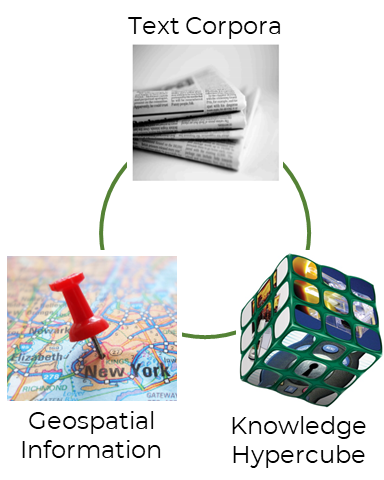

### Learning Objectives
This tutorial is designed for anyone who is interested in Natural Language Processing (NLP) in general, geospatial knowledge hypercube in particular, to gain hands-on experience with general-purpose NLP library as well as some state-of-the-art language models for solving information extraction (IE) and document classification tasks. The hypercube lays a foundation for knowledge discovery by combining text and geospatial data analytics. We hope this tutorial will bring you not only a general understanding about geospatial knowledge hypercube but mroe creative aspects on your own work.

The tutorial will guide you through the following steps:
- Import necessary libraries
- Load sample corpus
- Understand the pre-trained language model (PLM): BERT
- Perform general-purpose Named Entity Recognition (NER)
- Construct hypercube: geospatial dimension
- Construct hypercube: topic dimension

### Requirement
- Python >= 3.7
- NLTK (same as python)
- SpaCy 3.4
- PyTorch >= 1.7
- Transformers (by Hugging Face) >= 4.0

### Understand the Pre-trained Language Model (PLM): BERT
BERT is abbreviation for Bidirectional Encoder Representations from Transformers, origianally from a research paper by Google AI Language in 2018 [1]. It resolutionized a wide variety of NLP tasks, including question anwsering (QA), natural language inference (NLI). Different from the recent popular GPT (short for Generative Pre-trained Transformers) model in a unidirectional autoregressive fashion, BERT is bidirectional language model and better at natural language understanding.

[1] BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding. ArXiv'18

Figure below demonstrates how BERT handles natural language input, tokenizes words into embeddings (perceivable vectors by deep learning models), encodes and makes predictions for Named Entity Recognition (NER) task. As illustrated, BERT is trained to assign labels like B-PER (Beginning of Person), I-PER (Inside of Person), B-LOC (Beginning of Location) and O (not a named entity) etc.

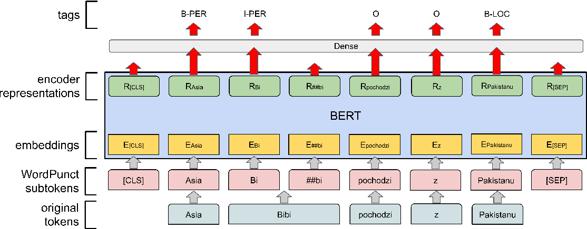

### Perform General-purpose Named Entity Recognition (NER)
Here we firstly show how to use SpaCy, a generic NLP library, to perform general purpose NER and visualize the results. For installation of SpaCy, please refer to [SpaCy's offical document](https://spacy.io/usage)

In [8]:
import os
import json
import spacy
from spacy import displacy    # visualizer
from tqdm import tqdm
from collections import defaultdict

# nlp = spacy.load("en_core_web_trf")     # accuracy
nlp = spacy.load("en_core_web_sm")    # efficiency

In [10]:
data_list = []
with open('./data/sample_NER.txt', encoding='utf-8') as f:
    readin = f.readlines()
    for line in tqdm(readin):
        data_list.append(line.strip())
print(f'Length of date_list:{len(data_list)}')
print(data_list[:1])

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.47it/s]

Length of date_list:1
['Dozens, if not more than a hundred, Midland-area residents gathered to seek refuge within the walls of Midland High School Tuesday night after the Edenville Dam failed to hold back a deluge of water. Midland officials warned residents living near the Tittabawassee River to evacuate. They are concerned the Sanford Dam, located a few miles northwest of the city and downstream of the Edenville Dam, will also fail. Some drove to the school at 1301 Eastlawn Drive to seek shelter. Others were brought in by bus.']


In [11]:
# set up output dir
out_dir = './output'
os.makedirs(out_dir, exist_ok=True)

In [12]:
with open(os.path.join(out_dir, 'ner_out.txt'), 'w') as fout:
    for text in tqdm(data_list):
        doc = nlp(text)
        displacy.serve(doc, style="ent")
        
        entity_dict = defaultdict(int)
        for entity in doc.ents:
            if entity.label_ in ['LOC', 'GPE', 'FAC', 'DATE', 'TIME']:    # LOCation, GeoPolitical Entity (i.e. countries, cities, states), FACility
                # entity_dict[entity.label_ + '_' + entity.text] += 1
                entity_dict[entity.text] += 1
                # text_seq = entity.text.split()
                # if text_seq[0].lower() in watershed_word or text_seq[-1].lower() in watershed_word:
                #     entity_dict[entity.text] += 1
        fout.write(json.dumps(entity_dict) + '\n')

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\znwang\Anaconda3\lib\site-packages\spacy\displacy\__init__.py:103: UserWarning: [W011] It looks like you're calling displacy.serve from within a Jupyter notebook or a similar environment. This likely means you're already running a local web server, so there's no need to make displaCy start another one. Instead, you should be able to replace displacy.serve with displacy.render to show the visualization.
  warnings.warn(Warnings.W011)



Using the 'ent' visualizer
Serving on http://0.0.0.0:5000 ...



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [07:19<00:00, 439.24s/it]

Shutting down server on port 5000.


### Construct Hypercube: Geospatial Dimension
Although SpaCy offers a generic tool for general-purpose Named Entity Recognition (NER), it may not be the optimal solution to extract geographic information from text corpus. Specifically, there is a line of research focusing on extracting location-related information, or toponyms, from raw texts. This sub-task of information extraction (IE) is known as geoparsing. Different from general NER, there are toponyms that are fine-grained and not appearing in gazetteers (like location dictionaries), or locations that are described by phrase, abbreviation, or local landmarks. Here we implement a state-of-the-art (SOTA) geoparser, called TopoBERT [1] for geoparsing. By fine-tuning the pretrained language model (PLM) - BERT, TopoBERT yields SOTA performance on geoparsing task.

[1] [TopoBERT: Plug and Play Toponym Recognition Module Harnessing Fine-tuned BERT](https://arxiv.org/ftp/arxiv/papers/2301/2301.13631.pdf). ArXiv'23

### (Optional) Fine-tuning Geoparser
Given the computational resource and time limitations, here we skip the training of TopoBERT model and directly load the pre-trained model weights. If you are interested in the fine-tuning process, please refer to the source codes in ./geoparser

In [14]:
import os
import json
import re
import queue
import nltk
from nltk import word_tokenize
from geoparser.backbone_models import *
from geoparser.dataset_process import *

In [15]:
nltk.download('punkt')
DEFAULT_TOPOBERT_PATH = './geoparser/topobert_cnn1d/'

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\znwang\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [16]:
class TopoBERT:
    def __init__(self, model_dir: str = DEFAULT_TOPOBERT_PATH):
        '''

        Args:
            model_dir (): Locate the dir that stores all the model files, or simply use the default path.
        '''
        try:
            self.model , self.tokenizer, self.model_config, self.training_config = self.load_model(model_dir)
            self.label_map = {"1": "O", "2": "B-LOC", "3": "I-LOC", "4": "[CLS]", "5": "[SEP]"}
            self.max_seq_length = self.training_config["--max_seq_length"]
            self.label_map = {int(k): v for k, v in self.label_map.items()}
            #self.device = "cuda:3" if torch.cuda.is_available() else "cpu"
            self.device = 'cpu'
            # Add model to device and set eval mode:
            self.model = self.model.to(self.device)
            self.model.eval()
        except Exception as e:
            print(e)

    def load_model(self, model_dir: str, model_config: str = "model_config.json"):
        # Load model config:
        model_config_file = os.path.join(model_dir, model_config)
        current_model_config = json.load(open(model_config_file))
        # Init model and load pretrained params:
        #model = BertSimpleNer.from_pretrained(model_dir)
        model = BertCNN1DNer.from_pretrained(model_dir, model_config=current_model_config)
        # Get training config:
        current_training_config = os.path.join(model_dir, 'train_config.json')
        current_training_config = json.load(open(current_training_config))
        # Init tokenizer:
        tokenizer = BertTokenizer.from_pretrained(model_dir, do_lower_case=current_training_config['--do_lower_case'])

        # Return all params:
        return model, tokenizer, current_model_config, current_training_config


    def tokenize(self, text: str):
        """ tokenize input"""
        words = word_tokenize(text)
        tokens = []
        valid_positions = []
        for i, word in enumerate(words):
            token = self.tokenizer.tokenize(word)
            tokens.extend(token)
            for i in range(len(token)):
                if i == 0:
                    valid_positions.append(1)
                else:
                    valid_positions.append(0)
        return tokens, valid_positions


    def preprocess(self, text: str):
        """ preprocess """
        tokens, valid_positions = self.tokenize(text)
        ## insert "[CLS]"
        tokens.insert(0, "[CLS]")
        valid_positions.insert(0, 1)
        ## insert "[SEP]"
        tokens.append("[SEP]")
        valid_positions.append(1)
        segment_ids = []
        for i in range(len(tokens)):
            segment_ids.append(0)
        input_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        input_mask = [1] * len(input_ids)
        while len(input_ids) < self.max_seq_length: # Padding
            input_ids.append(0)
            input_mask.append(0)
            segment_ids.append(0)
            valid_positions.append(0)
        return input_ids,input_mask,segment_ids,valid_positions


    def prettify_result(self, org_result):
        '''
        Input the original result list from the TopoBERT and formulate the
        Args:
            org_result (str): list of the predicted result for each token.

        Returns:
            Prettified result output with extra information
        '''
        combined_addresses = []  # A list of all address
        address_results = []  # A list of all predicted LOC
        full_address = ''  # Link all addresses in combined_addresses
        tmp_queue = queue.Queue(maxsize=20)
        tmp_address = ''
        for index, content in enumerate(org_result):
            if content['tag'] == 'B-LOC':  # If B-LOC, clear, save and enqueue
                # If not empty, empty it and save data:
                if not tmp_queue.empty():
                    # Get all content out first:
                    while not tmp_queue.empty():
                        tmp_address += str(tmp_queue.get()) + ' '
                    tmp_address = tmp_address.strip()
                    combined_addresses.append(tmp_address)
                    tmp_address = ''
                # Enqueue
                tmp_queue.put(content['word'].strip())
                # Save location entity:
                address_results.append(content['word'].strip())
            elif content['tag'] == 'I-LOC':  # If I-LOC, enqueue directly
                # Enqueue
                tmp_queue.put(content['word'].strip())
                # Save location entity:
                address_results.append(content['word'].strip())
            else:  # Else, clear and save
                if not tmp_queue.empty():
                    # Get all content out first:
                    while not tmp_queue.empty():
                        tmp_address += str(tmp_queue.get()) + ' '
                    tmp_address = tmp_address.strip()
                    combined_addresses.append(tmp_address)
                    tmp_address = ''
        # Deal with remaining data:
        if not tmp_queue.empty():
            # Get all content out first:
            while not tmp_queue.empty():
                tmp_address += str(tmp_queue.get()) + ' '
            tmp_address = tmp_address.strip()
            combined_addresses.append(tmp_address)
            tmp_address = ''

        # Get Full address:
        for add_content in combined_addresses:
            full_address += ' ' + add_content
        full_address = full_address.strip()

        # Construct output result:
        result_dict = {
            'combined_addresses': combined_addresses,
            'full_address': full_address,
            'address_results': address_results
        }

        return result_dict


    def predict(self, text: str):
        input_ids, input_mask, segment_ids, valid_ids = self.preprocess(text)
        input_ids = torch.tensor([input_ids], dtype=torch.long, device=self.device)
        input_mask = torch.tensor([input_mask], dtype=torch.long, device=self.device)
        segment_ids = torch.tensor([segment_ids], dtype=torch.long, device=self.device)
        valid_ids = torch.tensor([valid_ids], dtype=torch.long, device=self.device)
        with torch.no_grad():
            logits = self.model(input_ids, segment_ids, input_mask, None, valid_ids, None)
        logits = F.softmax(logits,dim=2)
        logits_label = torch.argmax(logits,dim=2)
        logits_label = logits_label.detach().cpu().numpy().tolist()[0]

        logits_confidence = [values[label].item() for values, label in zip(logits[0], logits_label)]

        logits = []

        pos = 0
        for index, mask in enumerate(valid_ids[0]):
            if index == 0:
                continue
            if mask == 1:
                logits.append((logits_label[index-pos], logits_confidence[index-pos]))
            else:
                pos += 1
        logits.pop()

        labels = [(self.label_map[label], confidence) for label, confidence in logits]
        words = word_tokenize(text)
        assert len(labels) == len(words)
        output = [{"word":word, "tag":label, "confidence":confidence} for word, (label, confidence) in zip(words, labels)]
        prettified_result = self.prettify_result(output)
        result_dict = prettified_result
        result_dict['org_result'] = output

        return result_dict


### HarveyTweet2017
HarveyTweet2017 is a [labeled Twitter dataset](https://github.com/geoai-lab/HowDoPeopleDescribeLocations), originally collected by [University of North Texas](https://digital.library.unt.edu/ark:/67531/metadc993940/). Each tweet contains some location description for disaster rescue. Below there are some examples in HarveyTweet2017.
- “12 Y/O BOY NEEDs RESCUED! **8100 Cypresswood Dr Spring TX 77379** They are trapped on second story! #houstonflood”
- “80 people stranded in a church!! **5547 Cavalcade St, Houston, TX 77026** #harveyrescue #hurricaneharvey”
- “Rescue needed: **2907 Trinity Drive, Pearland, Tx.** Need boat rescue 3 people, 2 elderly one is 90 not steady in her feet & cant swim. #Harvey”
- “Community is responding at shelters in **College Park High School** and **Magnolia High School** #TheWoodlands #Harvey...”
- “#Houston #HoustonFlood the **intersection of I-45 & N. Main Street**”

In [17]:
test_text = '''HarveyStorm over Austin TX at 8: 00 AM CDT via Weather Underground'''
current_geoparser = TopoBERT()
result = current_geoparser.predict(test_text)
print(result)

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'bert.pooler.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'bert.pooler.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


{'combined_addresses': [], 'full_address': '', 'address_results': [], 'org_result': [{'word': 'HarveyStorm', 'tag': '[CLS]', 'confidence': 0.46422553062438965}, {'word': 'over', 'tag': '[CLS]', 'confidence': 0.4642258882522583}, {'word': 'Austin', 'tag': '[CLS]', 'confidence': 0.4642317295074463}, {'word': 'TX', 'tag': '[CLS]', 'confidence': 0.4642227292060852}, {'word': 'at', 'tag': '[CLS]', 'confidence': 0.4642263948917389}, {'word': '8', 'tag': '[CLS]', 'confidence': 0.4642285108566284}, {'word': ':', 'tag': '[CLS]', 'confidence': 0.46422553062438965}, {'word': '00', 'tag': '[CLS]', 'confidence': 0.46422457695007324}, {'word': 'AM', 'tag': '[CLS]', 'confidence': 0.4642329812049866}, {'word': 'CDT', 'tag': '[CLS]', 'confidence': 0.46422213315963745}, {'word': 'via', 'tag': '[CLS]', 'confidence': 0.46422576904296875}, {'word': 'Weather', 'tag': '[CLS]', 'confidence': 0.4642335772514343}, {'word': 'Underground', 'tag': '[CLS]', 'confidence': 0.4642268121242523}]}


### Construct Hypercube: Topic Dimension
Current text classification methods typically require a good number of human-labeled documents as training data, which can be costly and difficult to obtain in real applications. Humans can perform classification without seeing any labeled examples but only based on a small set of words describing the categories to be classified. Motivated by this, we implement a state-of-the-art (SOTA) weakly-supervised document classification model, namely LOTClass [1], which only uses the label name of each class to train classification models on unlabeled data, without using any labeled documents. Pre-trained lanuage model (PLM) - BERT is used as general linguistic knowledge sources for category understanding and as representation learning models for document classification.

[1] [Text Classification using Label Names Only: A Language Model Self-training Approach](https://arxiv.org/pdf/2010.07245.pdf). EMNLP'20

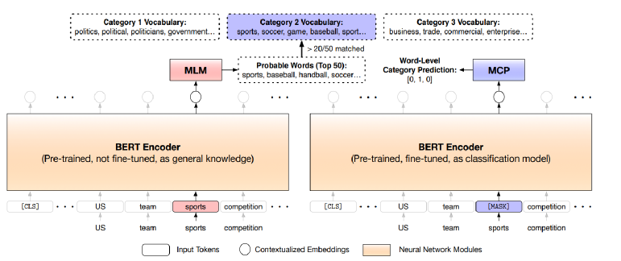

### (Optional) Training Document Classifier on Aging Dam
We collected a corpus of 188 Google News documents about dam failures under the path ./data/new_aging_dam.txt **Our task here is to automatically discover the coherent topic of each chunk of the document** so that we trained the LOTClass model given **four labels in natural language**:
- ecology
- human
- economy
- infrastructure

Given the computational resource and time limitations, here we skip the training of LOTClass model and directly load the pre-trained model weights. If you are interested in the self-training process, please refer to the source codes in ./classifier

### Word Expansion Results
- **ecology**: 'ecosystem', 'ecosystems', 'wildlife', 'vegetation', 'forest', 'global', 'nature', 'park', 'climate', 'canopy', 'native', 'ecology', 'biodiversity', 'habitats', 'eco', 'fauna', 'rainforest', 'plant', 'indigenous', 'fragile', 'conservation', 'tree', 'society' ...
- **human**: 'human', 'man', 'humans', 'individual', 'people', 'person', 'mankind', 'animal', 'normal', 'woman', 'civilian', 'humanity', 'civil', 'serious', 'player', 'moral', 'domestic', 'single', 'professional', 'mortal', 'live', 'american', 'male', 'internal', 'us', 'persons' ...
- **economy**: 'economic', 'economically', 'financial', 'economical', 'economy', 'economics', 'commercial', 'agricultural', 'industrial', 'economies', 'business', 'uneven', 'international', 'entertainment', 'employment', 'impact', 'annual', 'income' ...
- **infrastructure**: 'infrastructure', 'heritage', 'development', 'network', 'structure', 'equipment', 'technology', 'system', 'property', 'structures', 'architecture', 'construction', 'dam', 'education', 'embankment', 'grid', 'facilities', 'security', 'powerhouse', 'sanitation' ...

In [18]:
# break document into sentences

with open('./data/news_aging_dam.txt', 'r', encoding='utf-8') as f:
    for j, line in enumerate(f):
        # with open(out_file, 'a') as out:
        #     out.write(str(j))
        #     out.write('\n')

        doc = nlp(line)
        for sentence in doc.sents:
            with open('./data/news_aging_dam_sentences.txt', 'a', encoding='utf-8') as out:
                out.write(sentence.text)
                out.write('\n')

In [19]:
# check classification results

## load news - use first document as an example
with open('./data/news_aging_dam.txt', 'r', encoding='utf-8') as f:
    for j, line in enumerate(f):
        print(line)
        break

Midland-area residents evacuate to high school after dam failure threatens city - mlive.com Skip to ArticleSet weatherBack To Main MenuCloseCustomize Your WeatherSet Your Location:Enter City and State or Zip CodeSubmitMichiganAnn ArborFlintGrand Rapids/MuskegonJacksonKalamazooSaginaw/Bay CityAll MichiganSubscribeSaginaw and Bay City NewsMidland-area residents evacuate to high school after dam failure threatens cityUpdated: May. 20, 2020, 3:17 p.m. | Published: May. 19, 2020, 10:52 p.m.Midland High School served as a refuge site for Midland residents displaced by the Edenville Dam failure on May 19, 2020.1,478sharesBy Cole Waterman | Cole_Waterman@mlive.com MIDLAND, MI — Dozens, if not more than a hundred, Midland-area residents gathered to seek refuge within the walls of Midland High School Tuesday night after the Edenville Dam failed to hold back a deluge of water.Midland officials warned residents living near the Tittabawassee River to evacuate. They are concerned the Sanford Dam, lo

In [20]:
label_dict = {0: 'ecology',
              1: 'human',
              2: 'economy',
              3: 'infrastructure'}

with open('./data/news_aging_dam_sentences.txt', 'r', encoding='utf-8') as doc:
    with open('./classifier/out.txt', 'r', encoding='utf-8') as label:
        for j, (sentence, lab) in enumerate(zip(doc, label)):
            print(sentence, lab, label_dict[int(lab[0])], '\n')
            if j == 10:
                break

Midland-area residents evacuate to high school after dam failure threatens city - mlive.com Skip to ArticleSet
 3
 infrastructure 

weatherBack
 2
 economy 

To Main MenuCloseCustomize Your WeatherSet Your Location:Enter City and State or Zip CodeSubmitMichiganAnn
 2
 economy 

ArborFlintGrand Rapids/MuskegonJacksonKalamazooSaginaw/Bay CityAll MichiganSubscribeSaginaw and Bay City NewsMidland-area residents evacuate to high school after dam failure threatens cityUpdated:
 3
 infrastructure 

May. 20, 2020, 3:17 p.m. | Published: May. 19, 2020, 10:52 p.m.Midland High School served as a refuge site for Midland residents displaced by the Edenville Dam failure on May 19, 2020.1,478sharesBy Cole Waterman | Cole_Waterman@mlive.com MIDLAND, MI — Dozens, if not more than a hundred, Midland-area residents gathered to seek refuge within the walls of Midland High School Tuesday night after the Edenville Dam failed to hold back a deluge of water.
 3
 infrastructure 

Midland officials warned resid